# Deep Learning for Time Series Analysis
## Using PyTorch, fastai, and tsai

This notebook provides a practical introduction to modern deep learning techniques for time series analysis.

### What You'll Learn:
1. Setting up the environment
2. Data preparation for time series
3. Building models from scratch with PyTorch
4. Using tsai for high-level APIs
5. Different architectures (LSTM, CNN, Transformers)
6. Evaluation and forecasting

## 1. Installation and Setup

First, let's install the necessary libraries:

In [ ]:
# Uncomment to install required packages
# !pip install torch torchvision torchaudio
# !pip install fastai
# !pip install tsai
# !pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Generate Synthetic Time Series Data

We'll start with synthetic data to understand the concepts clearly. Later, you can apply these techniques to real datasets.

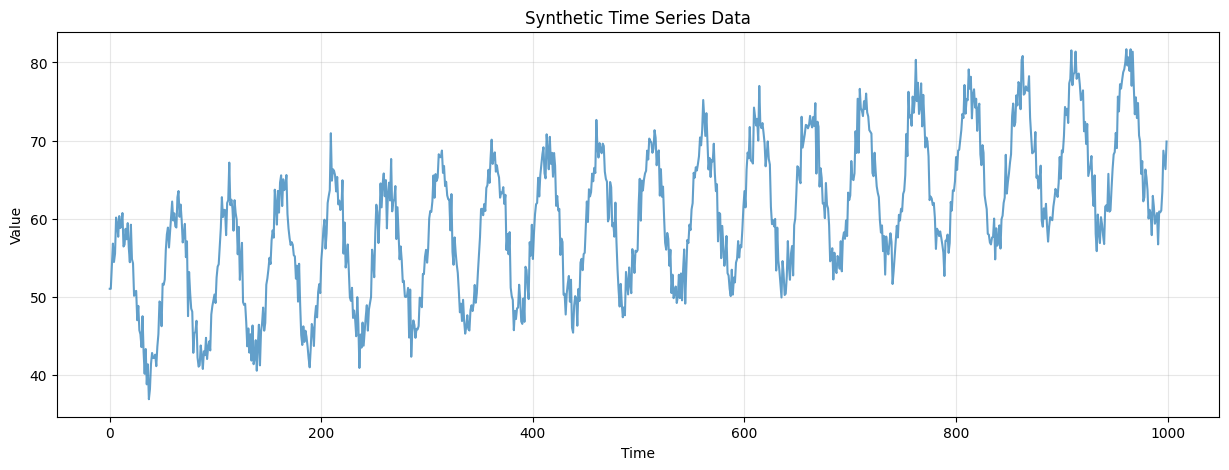

Data shape: (1000,)
Data range: [36.84, 81.70]


In [3]:
def generate_synthetic_timeseries(n_samples=1000, n_features=1):
    """
    Generate synthetic time series with trend, seasonality, and noise
    """
    time = np.arange(n_samples)
    
    # Trend component
    trend = 0.02 * time
    
    # Seasonal component (yearly pattern)
    seasonal = 10 * np.sin(2 * np.pi * time / 50)
    
    # Random noise
    noise = np.random.normal(0, 2, n_samples)
    
    # Combine components
    data = trend + seasonal + noise + 50  # Add baseline
    
    return time, data

# Generate data
time, data = generate_synthetic_timeseries(n_samples=1000)

# Visualize
plt.figure(figsize=(15, 5))
plt.plot(time, data, alpha=0.7)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Data shape: {data.shape}")
print(f"Data range: [{data.min():.2f}, {data.max():.2f}]")

## 3. Time Series Dataset Preparation

Critical concept: We need to create sliding windows of past observations to predict future values.

In [4]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series forecasting
    
    Args:
        data: 1D array of time series values
        window_size: Number of past time steps to use as input
        forecast_horizon: Number of future time steps to predict
    """
    def __init__(self, data, window_size=50, forecast_horizon=1):
        self.data = torch.FloatTensor(data)
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        
    def __len__(self):
        return len(self.data) - self.window_size - self.forecast_horizon + 1
    
    def __getitem__(self, idx):
        # Input: window_size past observations
        x = self.data[idx:idx + self.window_size]
        # Target: next forecast_horizon observations
        y = self.data[idx + self.window_size:idx + self.window_size + self.forecast_horizon]
        
        return x.unsqueeze(-1), y  # Add feature dimension to x

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Split into train/validation/test (70/15/15)
train_size = int(0.7 * len(data_normalized))
val_size = int(0.15 * len(data_normalized))

train_data = data_normalized[:train_size]
val_data = data_normalized[train_size:train_size + val_size]
test_data = data_normalized[train_size + val_size:]

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

# Create datasets
window_size = 50
forecast_horizon = 10  # Predict next 10 steps

train_dataset = TimeSeriesDataset(train_data, window_size, forecast_horizon)
val_dataset = TimeSeriesDataset(val_data, window_size, forecast_horizon)
test_dataset = TimeSeriesDataset(test_data, window_size, forecast_horizon)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check a sample
x_sample, y_sample = train_dataset[0]
print(f"\nInput shape: {x_sample.shape} (window_size, features)")
print(f"Target shape: {y_sample.shape} (forecast_horizon,)")

Train size: 700
Validation size: 150
Test size: 150

Input shape: torch.Size([50, 1]) (window_size, features)
Target shape: torch.Size([10]) (forecast_horizon,)


In [6]:
  device = torch.device('cpu')                                                                                                                                                                                                        
  print(f"Using device: {device}")                                                                                                                                                                                                    
                                       

Using device: cpu


## 4. Model Architecture #1: LSTM (Baseline)

LSTM (Long Short-Term Memory) networks are a classic choice for time series. They can capture long-term dependencies.

In [7]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, 
                 forecast_horizon=10, dropout=0.2):
        super(LSTMForecaster, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, forecast_horizon)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last hidden state
        last_hidden = lstm_out[:, -1, :]
        
        # Predict future values
        output = self.fc(last_hidden)
        
        return output

# Instantiate model
lstm_model = LSTMForecaster(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    forecast_horizon=forecast_horizon,
    dropout=0.2
).to(device)

print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

LSTMForecaster(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

Total parameters: 52,842


## 5. Training Loop

Standard PyTorch training loop with validation.

Training LSTM model...
Epoch 10/50 - Train Loss: 0.1025, Val Loss: 0.2306
Epoch 20/50 - Train Loss: 0.0871, Val Loss: 0.1813
Epoch 30/50 - Train Loss: 0.0952, Val Loss: 0.1746
Epoch 40/50 - Train Loss: 0.0796, Val Loss: 0.1265
Epoch 50/50 - Train Loss: 0.0728, Val Loss: 0.1169


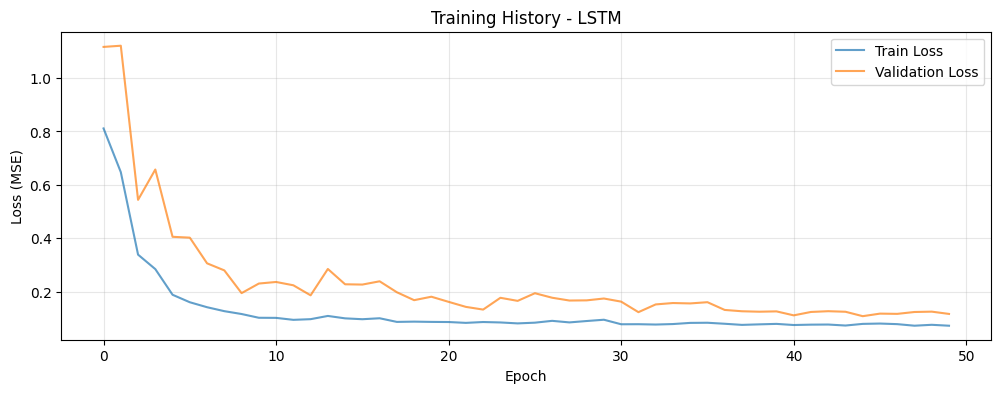

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# Training configuration
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                         factor=0.5, patience=5)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Training LSTM model...")
for epoch in range(num_epochs):
    train_loss = train_epoch(lstm_model, train_loader, criterion, optimizer, device)
    val_loss = validate(lstm_model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History - LSTM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Model Architecture #2: CNN for Time Series

CNNs can be surprisingly effective for time series by capturing local patterns.

In [9]:
class CNNForecaster(nn.Module):
    def __init__(self, input_size=1, forecast_horizon=10, dropout=0.2):
        super(CNNForecaster, self).__init__()
        
        # CNN layers with increasing dilation for multi-scale patterns
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=4, dilation=4)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, forecast_horizon)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        # Conv1d expects (batch, features, seq_len)
        x = x.transpose(1, 2)
        
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        
        # Global pooling
        x = self.pool(x).squeeze(-1)
        
        # Prediction
        output = self.fc(x)
        
        return output

# Instantiate and train CNN model
cnn_model = CNNForecaster(
    input_size=1,
    forecast_horizon=forecast_horizon,
    dropout=0.2
).to(device)

print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

CNNForecaster(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

Total parameters: 39,946


## 7. Using tsai Library (High-Level API)

Now let's use tsai for a more streamlined workflow similar to fastai.

In [10]:
# Uncomment if tsai is installed
# from tsai.all import *

# Example of using tsai (pseudo-code - requires tsai installation)
"""
# Prepare data in tsai format
X = np.array([train_data[i:i+window_size] for i in range(len(train_data)-window_size-forecast_horizon)])
y = np.array([train_data[i+window_size:i+window_size+forecast_horizon] for i in range(len(train_data)-window_size-forecast_horizon)])

# Create splits
splits = get_splits(y, valid_size=0.2, test_size=0.2, show_plot=False)

# Create dataloaders
tfms = [None, TSRegression()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=32)

# Create model (InceptionTime is state-of-the-art)
model = InceptionTime(dls.vars, dls.c, dls.len)

# Train with fastai Learner
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae])
learn.fit_one_cycle(50, 1e-3)

# Make predictions
preds, targets = learn.get_preds()
"""

print("""To use tsai:
1. Install: pip install tsai
2. Import: from tsai.all import *
3. Use high-level APIs similar to fastai
4. Access state-of-the-art models: InceptionTime, XceptionTime, TST (Transformer)""")

To use tsai:
1. Install: pip install tsai
2. Import: from tsai.all import *
3. Use high-level APIs similar to fastai
4. Access state-of-the-art models: InceptionTime, XceptionTime, TST (Transformer)


## 8. Evaluation and Visualization

Let's evaluate our models and visualize predictions.

LSTM Model Performance:
  MSE: 0.2426
  MAE: 0.4147
  RMSE: 0.4926


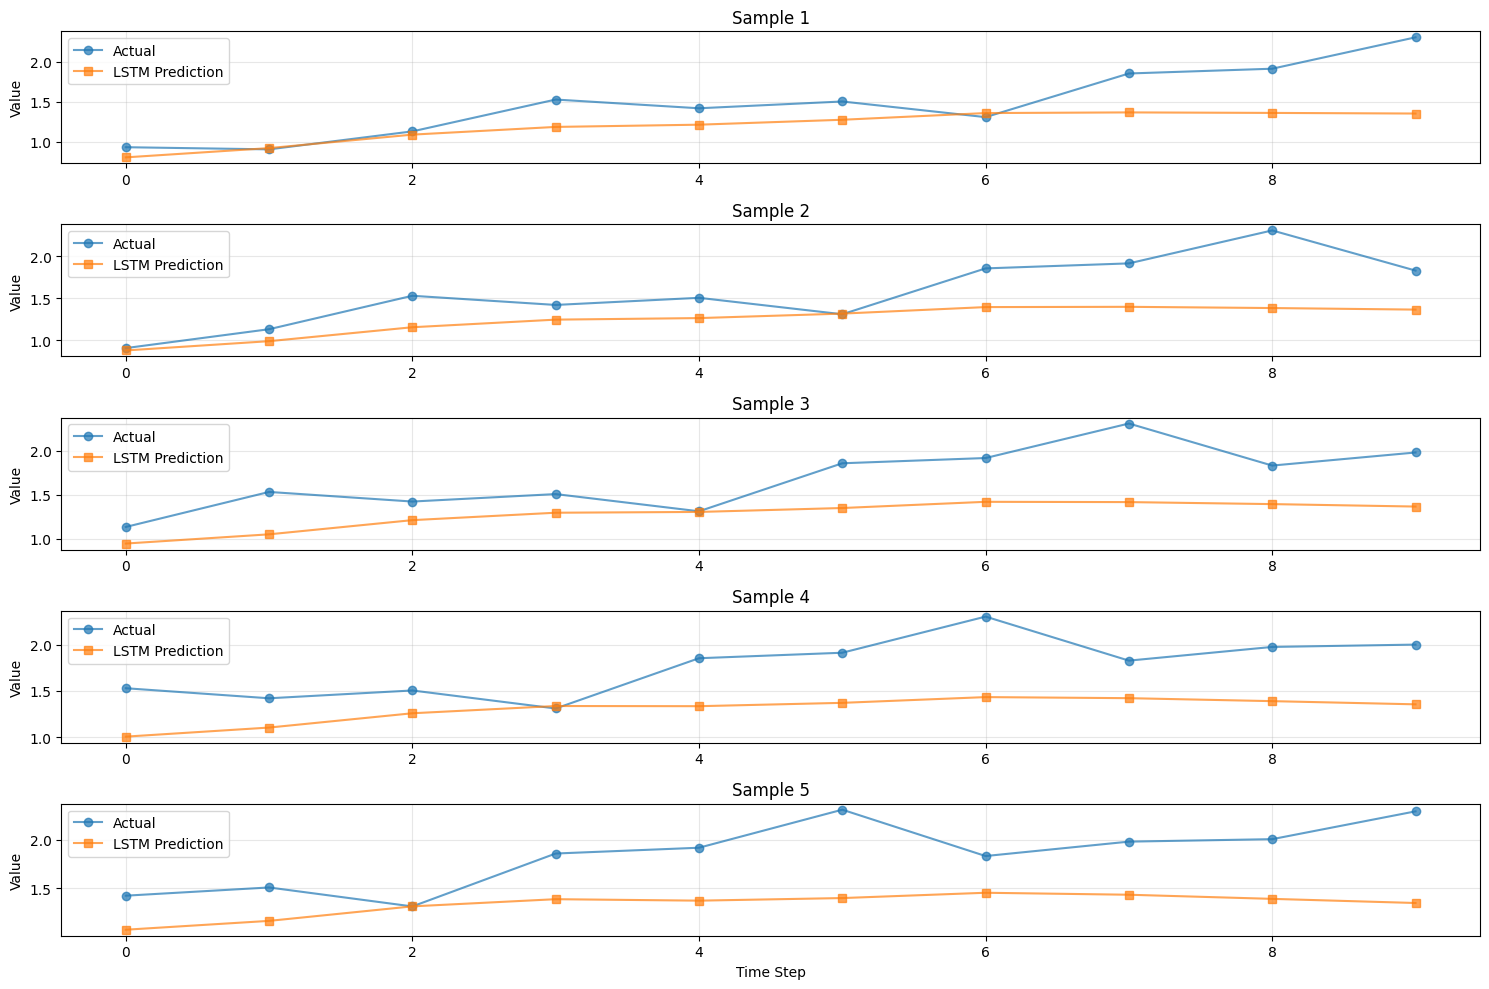

In [11]:
def evaluate_model(model, test_loader, device):
    """Evaluate model and return predictions and targets"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            predictions = model(x_batch)
            
            all_preds.append(predictions.cpu().numpy())
            all_targets.append(y_batch.numpy())
    
    predictions = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Calculate metrics
    mse = np.mean((predictions - targets) ** 2)
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(mse)
    
    return predictions, targets, {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

# Evaluate LSTM
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
lstm_preds, targets, lstm_metrics = evaluate_model(lstm_model, test_loader, device)

print("LSTM Model Performance:")
for metric, value in lstm_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Visualize predictions
n_samples_to_plot = 5
fig, axes = plt.subplots(n_samples_to_plot, 1, figsize=(15, 10))

for i in range(n_samples_to_plot):
    axes[i].plot(targets[i], label='Actual', marker='o', alpha=0.7)
    axes[i].plot(lstm_preds[i], label='LSTM Prediction', marker='s', alpha=0.7)
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title(f'Sample {i+1}')

axes[-1].set_xlabel('Time Step')
plt.tight_layout()
plt.show()

## 9. Advanced: Transformer for Time Series

Transformers have shown excellent results for time series, especially for long sequences.

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerForecaster(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, 
                 forecast_horizon=10, dropout=0.1):
        super(TransformerForecaster, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Output projection
        self.fc = nn.Linear(d_model, forecast_horizon)
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        
        # Use last timestep for prediction
        x = x[:, -1, :]
        output = self.fc(x)
        
        return output

# Instantiate Transformer model
transformer_model = TransformerForecaster(
    input_size=1,
    d_model=64,
    nhead=4,
    num_layers=2,
    forecast_horizon=forecast_horizon,
    dropout=0.1
).to(device)

print(transformer_model)
print(f"\nTotal parameters: {sum(p.numel() for p in transformer_model.parameters()):,}")

TransformerForecaster(
  (input_projection): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 100,746


## 10. Next Steps and Real-World Applications

### Try These Real Datasets:
1. **Finance**: Stock prices, cryptocurrency data
2. **Weather**: Temperature, precipitation forecasting
3. **Energy**: Electricity consumption, solar generation
4. **Retail**: Sales forecasting, demand prediction

### Advanced Techniques to Explore:
- **Multi-variate forecasting**: Multiple related time series
- **Attention mechanisms**: Visualize what the model focuses on
- **Probabilistic forecasting**: Predict distributions instead of point estimates
- **Transfer learning**: Pre-train on one dataset, fine-tune on another
- **Ensemble methods**: Combine multiple models

### Recommended Libraries:
- **tsai**: High-level API built on fastai
- **PyTorch Forecasting**: Specialized for forecasting tasks
- **Darts**: User-friendly forecasting library
- **GluonTS**: Probabilistic time series models

### Resources:
- tsai documentation: https://timeseriesai.github.io/tsai/
- PyTorch Forecasting: https://pytorch-forecasting.readthedocs.io/
- Papers: "Temporal Fusion Transformers", "N-BEATS", "Informer"

## 11. Exercise: Your Turn!

Try these exercises to deepen your understanding:

1. **Experiment with hyperparameters**: Change window_size, hidden_size, number of layers
2. **Load real data**: Use pandas to load a CSV file with time series data
3. **Multi-step ahead prediction**: Modify the model to predict multiple steps iteratively
4. **Add external features**: Include additional variables (e.g., day of week, holidays)
5. **Compare architectures**: Train CNN and Transformer models, compare performance
6. **Implement attention visualization**: See what patterns the model learns
7. **Try different loss functions**: MAE, Huber loss, quantile loss for probabilistic forecasting

In [ ]:
# Your experiments here!
# Try modifying the code above or implementing new features